# Code for figures in problem a)

In this notebook we do experiments with minimising OLS and Ridge cost functions for the Franke function for different methods and hyperparametres

In [34]:
# IMPORT
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))
from Code.descent_methods import *
from Code.utilities import MSE_grad, train_test_split, plot_test_results, MSE_grad, MSELoss

# Import tools from the first project 
from Code.project1_tools import feature_matrix_2d, r2_sampling

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [35]:
# Sample points and split in train and test
num_features = 15
beta0 = {"b" : np.random.random(num_features)}
num_points = 100
data = r2_sampling(num_points, sigma2=0.3)
x, y, z = data["x"], data["y"], data["z"]
X = feature_matrix_2d(x, y, num_features)
X_train, y_train, X_test, y_test, test_index = train_test_split(X, z, 0.2)
# Quickfix...
y_train, y_test = np.squeeze(y_train), np.squeeze(y_test)

# Number of of minibatch when using batch size 10
m = int(len(y_train) / 10) 
epochs = 50

# Define the polynomial fit model
def model(beta, X):
    return np.dot(X, beta["b"])

### Analytic gradients
from Code.utilities import OLS_grad, ridge_grad

# Our framework requires standardised gradient taking parametres beta, X, y
def OLS_train_grad(model):
    return lambda beta, X, y: {"b" : OLS_grad(beta, X, y, model)}

def ridge_train_grad(model, lam):
    return lambda beta, X, y : {"b" : ridge_grad(beta, X, y, model, lam)}


### Jax gradients, need loss functions
from Code.utilities import Ridge_loss_method, MSELoss_method

# With these, all we need to find gradient is
from jax import grad as grad_wrt_to_loss

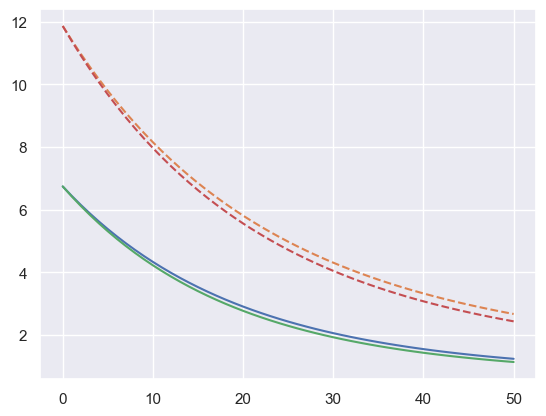

In [36]:
# Initialise beta
n_epochs = 100


lam=0.1
lr = 0.5

for grad in [OLS_train_grad(model), ridge_train_grad(model, lam)]:
    result_GD = GD(X_train, y_train, X_test, y_test, 
                grad_method=grad, 
                n_epochs=epochs, 
                lr=lr,
                beta0=beta0, 
                test_loss_func=(MSELoss_method(model)))

    plt.plot(result_GD["train_loss_list"])
    plt.plot(result_GD["test_loss_list"], linestyle="--")

plt.show()

In [37]:
"""
### analysis of results for OLS and RIDGE as function of
- lr
- #mini batches
- #epochs
- algorithm

- lambda for ridge!
    - use seabord ... to show results as function of lr and lam !
"""


'\n### analysis of results for OLS and RIDGE as function of\n- lr\n- #mini batches\n- #epochs\n- algorithm\n\n- lambda for ridge!\n    - use seabord ... to show results as function of lr and lam !\n'

### Seaborn Ridge
Ridge as function of learning rate and lambda

use seabord ... to show results as function of lr and lam !


[[11.86236763 11.86236763 11.86236763 11.86236763 11.86236763 11.86236763
  11.86233139 11.86211777 11.86114693 11.85680676]
 [11.85904884 11.85904884 11.85904884 11.85904884 11.8590374  11.8589735
  11.85878086 11.8578434  11.85347557 11.83327484]
 [11.84351635 11.84351635 11.8435154  11.843503   11.84348488 11.84326458
  11.84231377 11.83797836 11.81780815 11.724617  ]
 [11.77192497 11.77192211 11.77191448 11.77187157 11.77167225 11.77074146
  11.7664156  11.74636841 11.65377998 11.23386192]
 [11.44628239 11.44627571 11.44623375 11.44603729 11.44513512 11.440938
  11.42148781 11.33165836 10.92424202  9.22408199]
 [10.07065678 10.07062054 10.07045174 10.06966209 10.06601238 10.04908466
   9.97089386  9.61624432  8.13559914  3.83883238]
 [ 5.84995508  5.84986162  5.84943342  5.84744024  5.83819723  5.79550362
   5.60174322  4.79075146  2.40818357  0.39630353]
 [ 1.4791075   1.47903407  1.4786942   1.47711742  1.46982932  1.43666553
   1.29607797  0.85746843  0.37474805  0.30127135]
 [ 

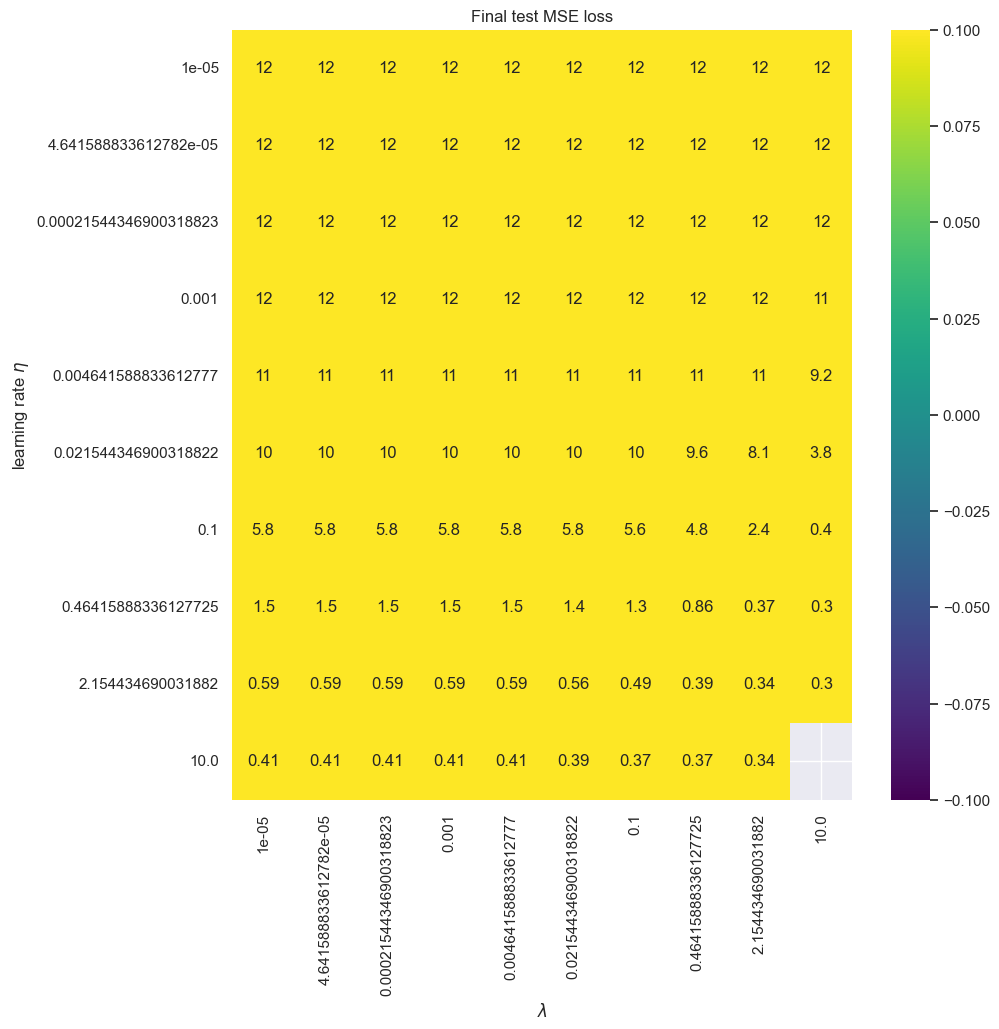

In [40]:
# ensure the same random numbers appear every time
np.random.seed(0)

# Fixed parametres
epochs = 100

# Values for experiment
lr_vals = np.logspace(-5, 1, 10)
lam_vals = np.logspace(-5, 1, 10)
results = np.zeros((len(lr_vals), len(lam_vals)))

# Perform algorithm for each value
for i, lr in enumerate(lr_vals):
    for j, lam in enumerate(lam_vals):

        # Get gradient function for given lambda
        grad = ridge_train_grad(model, lam)

        # Perform experiment
        result_GD = GD(X_train, y_train, X_test, y_test, 
                    grad_method=grad, 
                    n_epochs=epochs, 
                    lr=lr,
                    beta0=beta0, 
                    test_loss_func=(MSELoss_method(model)))

        # Append the final error from training
        results[i, j] = result_GD["test_loss_list"][-1]

print(results)

sns.set()
fig, ax = plt.subplots(figsize = (10, 10))
df = pd.DataFrame(results, index=lam_vals, columns=lr_vals)
sns.heatmap(df, annot=True, ax=ax, cmap="viridis")
ax.set_title("Final test MSE loss")
ax.set_ylabel("learning rate $\eta$")
ax.set_xlabel("$\lambda$")
plt.show()